Linear Regression for soil property prediction via SSL Data 

Author: Nafiseh Kakhani

Latest version: 22.04.2024

Project: Archaeological Insights Through Soil Analysis

In [ ]:
from helper import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import copy
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
# from cubist import Cubist
import joblib
from tqdm import tqdm

### Output pre processing 

In [ ]:
# Output data path 
file_path = ".\\data\\Wet_chemistry.csv"
output = preprocess_data(file_path)
output.head()

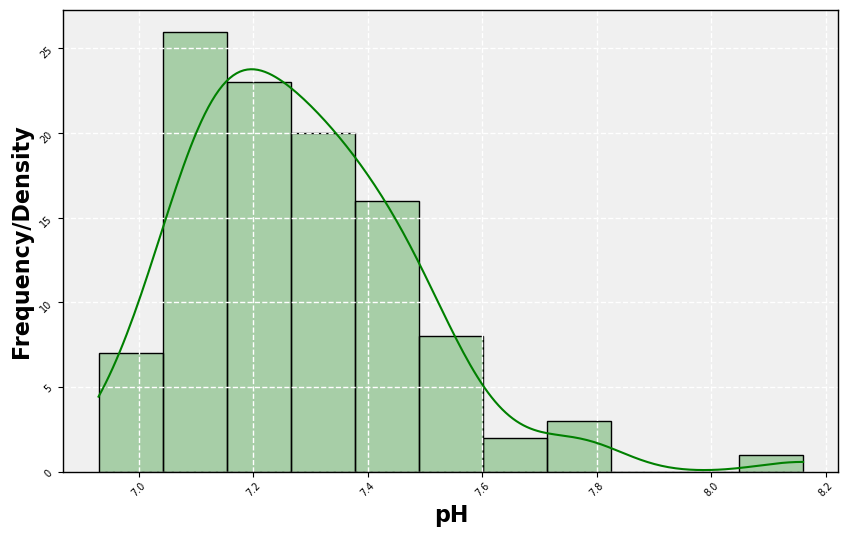

In [3]:
# Data visualization for different properties
plot_histogram_and_kde(output, 'pH')

### Inputs

In [4]:
df = pd.read_csv(".\\data\\spectra\\Full_spectra_SG 2.11.csv")

EXP_NAME = 'SG_2_11'
df.rename( columns={'Unnamed: 0':'Lab_ID'}, inplace=True )
df.head()

,Lab_ID,SG.2.11.4475,SG.2.11.4471,SG.2.11.4467,SG.2.11.4463,SG.2.11.4459,SG.2.11.4455,SG.2.11.4451,SG.2.11.4447,SG.2.11.4443,...,SG.2.11.555,SG.2.11.551,SG.2.11.547,SG.2.11.543,SG.2.11.539,SG.2.11.535,SG.2.11.531,SG.2.11.527,SG.2.11.523,SG.2.11.519
0,41612,-0.000054,-0.000049,-0.000044,-0.000040,-0.000038,-3.618202e-05,-0.000036,-0.000037,-0.000039,...,0.018555,0.019592,0.020251,0.020553,0.020383,0.019501,0.017485,0.014233,0.010149,0.005962
1,41614,-0.000015,-0.000013,-0.000009,-0.000004,-0.000001,4.041832e-07,0.000003,0.000005,0.000006,...,0.011636,0.012881,0.013714,0.014147,0.014161,0.013630,0.012313,0.010169,0.007497,0.004804
2,41615,-0.000069,-0.000064,-0.000059,-0.000052,-0.000046,-4.355206e-05,-0.000042,-0.000043,-0.000043,...,0.020855,0.022256,0.023136,0.023585,0.023526,0.022666,0.020563,0.017048,0.012470,0.007726
3,41616,-0.000041,-0.000035,-0.000029,-0.000023,-0.000020,-1.894998e-05,-0.000018,-0.000019,-0.000021,...,0.021405,0.022299,0.022750,0.022852,0.022447,0.021200,0.018627,0.014563,0.009483,0.004331
4,41618,-0.000041,-0.000035,-0.000030,-0.000025,-0.000023,-2.111140e-05,-0.000022,-0.000024,-0.000027,...,0.021212,0.022202,0.022809,0.023059,0.022839,0.021686,0.019117,0.015039,0.009974,0.004844


In [5]:
inputs = pd.merge(output, df, on='Lab_ID', how='left')

### Linear Regression as baseline

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

end_col = 12

# Assuming inputs is your DataFrame containing the data
X = inputs.iloc[:, end_col:].values  # Features
y = inputs.iloc[:, 2:end_col].values # Responses

# Split the data into training and test sets (85% training, 15% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Initialize the linear regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

print(y_pred.shape)


(16, 10)


In [7]:
# Create a DataFrame
columns = ['Observed_pH', 'Observed_CaCO3', 'Observed_Nt', 'Observed_Ct', 'Observed_Corg', 
           'Observed_Sand', 'Observed_Silt', 'Observed_Clay', 'Observed_Micron', 'Observed_MWD',
           'Predicted_pH', 'Predicted_CaCO3', 'Predicted_Nt', 'Predicted_Ct', 'Predicted_Corg', 
           'Predicted_Sand', 'Predicted_Silt', 'Predicted_Clay', 'Predicted_Micron', 'Predicted_MWD']

df = pd.DataFrame(np.concatenate([y_test, y_pred], axis=1), columns=columns)

# Save the DataFrame to a CSV file
df.to_csv(f'test_predictions_SanityCheck_{EXP_NAME}.csv', index=False)

print('Test predictions saved.')


Test predictions saved.


### Metrics dict

In [8]:
# Define the list of parameters
parameters = ['pH', 'CaCO3', 'Nt', 'Ct', 'Corg', 'Sand', 'Silt', 'Clay', 'Micron', 'MWD']

# Initialize lists to store metric results
mae_list = []
r2_list = []
rmse_list = []
rmsle_list = []
ccc_list = []
rpiq_list = []

# Iterate over each parameter
for parameter in parameters:
    # Extract observed and predicted values for the current parameter
    observed = df[f'Observed_{parameter}']
    predicted = df[f'Predicted_{parameter}']
    
    # Compute metrics
    mae = mean_absolute_error(observed, predicted)
    r2 = r2_score(observed, predicted)
    rmse = mean_squared_error(observed, predicted, squared=False)
    ccc = concordance_cc(observed, predicted)

    # Calculate the first and third quantiles
    Q1 = np.percentile(predicted, 25)
    Q3 = np.percentile(predicted, 75)

    rpiq = (Q3-Q1) / rmse
    
    # Append results to lists
    mae_list.append(mae)
    r2_list.append(r2)
    rmse_list.append(rmse)
    ccc_list.append(ccc)
    rpiq_list.append(rpiq)

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Parameter': parameters,
    'MAE': mae_list,
    'R2': r2_list,
    'RMSE': rmse_list,
    'CCC': ccc_list,
    'RPIQ': rpiq_list
})

# Save the results to a CSV file
results_df.to_csv(f'metric_SanityCheck_results_{EXP_NAME}.csv', index=False)

print('Metric results saved.')

Metric results saved.
